# Density Ratio Trick
### (Trik Ilorazu Funkcji Gęstości Prawdopodobieństwa)

work based on Louis Tiao article: https://tiao.io/post/density-ratio-estimation-for-kl-divergence-minimization-between-implicit-distributions/

---

Density Ratio Trick to technika określająca podobieństwo pomiędzy dwiema funkcjami gęstości prawdopodobieństwa
(estymuje ich iloraz). Używana jest przy wyliczaniu wartości Dywergencji Kullbacka-Leiblera będącego miarą podobieństwa dwóch rozkładów.

W prostym i akademickim przypadku mamy do dyspozycji dwie funkcje gęstości prawdopodobieństwa opisane
równaniami. Policzenie ich ilorazu nie jest problemem. Możemy naiwnie wyliczyć ich stosunek, przechodząc po każdym punkcie X lub skorzystać
ze wzorów, jeśli wiemy, że rozkłady są Gaussowskie i znamy ich wariancję i średnią.
Zadanie jest utrudnione w przypadku gdy nie dysponujemy postacią analityczną rozkładu a jedynie próbkami (samplami) z tego rozkładu.
W takiej sytuacji często niemożliwe jest wyznaczenie analitycznej formy pierwotnego rozkładu.

Zacznijmy jednak od początku, czyli sytuacji, w której dwa rozkłady są określone funkcjami. Ich iloraz może zostać wyznaczony
bez większych problemów.

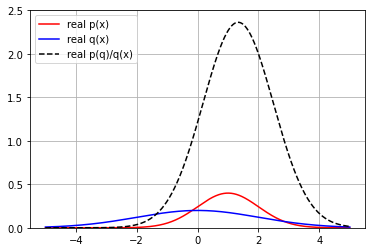

In [378]:
import torch
import matplotlib.pyplot as plt

from torch.distributions import normal

def log_density_ratio(p, q):
    def log_ratio(point):
        return p.log_prob(point) - q.log_prob(point)

    return log_ratio

def density_ratio(p, q):
    log_ratio = log_density_ratio(p, q)

    def ratio(point):
        return torch.exp(log_ratio(point))

    return ratio

def get_discrete_distribution_values(p, xp):
    values = torch.exp(p.log_prob(xp))
    values = torch.div(values, torch.sum(values))

    return values

# define two probability density distributions
mu1, std1 = torch.tensor(1.0), torch.tensor(1.0)
mu2, std2 = torch.tensor(0.0), torch.tensor(2.0)
p_real = normal.Normal(mu1, std1)
q_real = normal.Normal(mu2, std2)

# calculate their ratios for given space X
x = torch.linspace(-5, 5, 10000)
ratio = density_ratio(p_real, q_real)(x)

# and plot results
plt.figure()
plt.plot(x, torch.exp(p_real.log_prob(x)), c='r', label='real p(x)')
plt.plot(x, torch.exp(q_real.log_prob(x)), c='b', label='real q(x)')
plt.plot(x, ratio, c='k', linestyle='--', label='real p(q)/q(x)')
plt.legend()
plt.grid()
plt.ylim(0, 2.5)
plt.xlim(-5.5, 5.5)
plt.show()

Docelowa wartość Dywergencji KL (miara podobieństwa rozkładów) również może zostać obliczona na wiele różnych sposobów:

In [379]:
from torch.distributions import kl_divergence

mc_no_samples = 50000
xp_mc_samples = p_real.sample((mc_no_samples,))

p_values = get_discrete_distribution_values(p_real, x)
q_values = get_discrete_distribution_values(q_real, x)
plot_div = torch.dot(p_values, torch.log(torch.div(p_values, q_values)))
real_div = kl_divergence(p_real, q_real)
gauss_div = torch.log(std2) - torch.log(std1) - (1 / 2 * (1 - (((std1**2)+((mu1-mu2)**2)) / std2 ** 2)))
monte_carlo = torch.mean(torch.log(torch.exp(p_real.log_prob(xp_mc_samples))/torch.exp(q_real.log_prob(xp_mc_samples))))

print(f"pytorch kl-divergence ({real_div:.6f})")
print(f"gaussians' based analytical kl-divergence ({gauss_div:.6f})")
print(f"plot divergence based on integral calculation: ({plot_div:.6f})")
print(f"monte carlo kl divergence estimation: ({monte_carlo:.6f})")

pytorch kl-divergence (0.443147)
gaussians' based analytical kl-divergence (0.443147)
plot divergence based on integral calculation: (0.430858)
monte carlo kl divergence estimation: (0.438970)


Wyliczanie KL i porównywanie dwóch dystrybucji komplikuje się w momencie, gdy nie są one jawnie podane.
Współczynnik KL jest dany równaniem (przybliżenie metodą monte carlo):

<img src=
"https://render.githubusercontent.com/render/math?math=%5Ctextstyle+%5Cbegin%7Balign%2A%7D%0ADL_%7Bkl%7D%5Cbigg%5Bp%28x%29%7C%7Cq%28x%29%5Cbigg%5D%3D%5Cmathbb%7BE%7D_%7Bp%28x%29%7D%5B%5Clog%7Br%5E%7B%2A%7D%28x%29%7D%5D%3D%5Cfrac%7B1%7D%7BM%7D%5Csum_%7Bi%3D1%7D%5E%7BM%7D%5Clog%7Br%5E%7B%2A%7D%28x_%7Bp%7D%5E%7Bi%7D%7D%29%0A%5Cend%7Balign%2A%7D%0A"
alt="\begin{align*}
DL_{kl}\bigg[p(x)||q(x)\bigg]=\mathbb{E}_{p(x)}[\log{r^{*}(x)}]=\frac{1}{M}\sum_{i=1}^{M}\log{r^{*}(x_{p}^{i}})
\end{align*}
">

Aby wyliczyć wartość KL metodą Monte Carlo, jednocześnie nie znając analitycznej formy rozkładów p(x) i q(x) estymuje się wartość <img src="https://render.githubusercontent.com/render/math?math=r^{*}=\frac{p(x)}{q(x)}">
z użyciem optymalnego klasyfikatora probabilistycznego. W modelu tym wyjściem jest prawdopodobieństw przynależności do klasy p(x).

Ale czy że rzeczywiście istnieje związek pomiędzy wyjściem klasyfikatora a r*(x)?

Mając zbalansowany dataset <img src="https://render.githubusercontent.com/render/math?math=X={\{x_{p_1}, ..., x_{p_i}, x_{q_1}, ..., x_{q_i}\}}"> ze
zbiorem etykiet <img src="https://render.githubusercontent.com/render/math?math=Y={\{1, ..., 1, 0, ..., 0\}}"> dowodzimy, że:

<img src=
"https://render.githubusercontent.com/render/math?math=%5Ctextstyle+%5Cbegin%7Balign%2A%7D%0Ar%5E%7B%2A%7D%3D%5Cfrac%7Bp%28x%29%7D%7Bq%28x%29%7D%3D%5Cfrac%7BP%28x%7Cy%3D1%29%7D%7BP%28x%7Cy%3D0%29%7D%3D%0A%5Cbig%28%5Cfrac%7BP%28y%3D1%7Cx%29p%28x%29%7D%7Bp%28y%3D1%29%7D%5Cbig%29%5Cbig%28%5Cfrac%7BP%28y%3D0%7Cx%29p%28x%29%7D%7Bp%28y%3D0%29%7D%5Cbig%29%5E%7B-1%7D%3D%0A%5Cfrac%7BP%28y%3D0%29%7D%7BP%28y%3D1%29%7D%5Cbig%28%5Cfrac%7BP%28y%3D1%7Cx%29%7D%7BP%28y%3D0%7Cx%29%7D%5Cbig%29%3D%5Cfrac%7BP%28y%3D1%7Cx%29%7D%7BP%28y%3D0%7Cx%29%7D%0A%5Cend%7Balign%2A%7D%0A"
alt="\begin{align*}
r^{*}=\frac{p(x)}{q(x)}=\frac{P(x|y=1)}{P(x|y=0)}=
\big(\frac{P(y=1|x)p(x)}{p(y=1)}\big)\big(\frac{P(y=0|x)p(x)}{p(y=0)}\big)^{-1}=
\frac{P(y=0)}{P(y=1)}\big(\frac{P(y=1|x)}{P(y=0|x)}\big)=\frac{P(y=1|x)}{P(y=0|x)}
\end{align*}
">

Użyto twierdzenia Bayesa <img src="https://render.githubusercontent.com/render/math?math=P(y|x)=\frac{P(x|y)P(y)}{P(x)}"> w trzecim rozwinięciu i założono, że zbiór danych jest zbalansowany, tj. jest tyle samo sampli z
p(x) co z q(x).


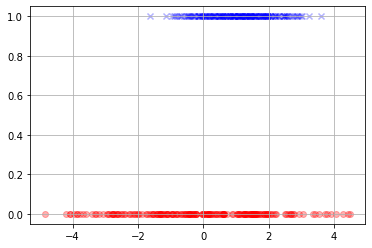

In [250]:
p_samples = p_real.sample((200,))
q_samples = q_real.sample((200,))

plt.scatter(p_samples, [1]*len(p_samples), c='b', marker='x', alpha=0.3)
plt.scatter(q_samples, [0]*len(q_samples), c='r', marker='o', alpha=0.3)
plt.grid()
plt.show()

Wiemy, że:

<img src=
"https://render.githubusercontent.com/render/math?math=%5Ctextstyle+%5Cbegin%7Balign%2A%7D%0Ar%5E%7B%2A%7D%3D%5Cfrac%7Bp%28x%29%7D%7Bq%28x%29%7D%3D%5Cfrac%7BP%28y%3D1%7Cx%29%7D%7BP%28y%3D0%7Cx%29%7D%0A%3D%5Cfrac%7BP%28y%3D1%7Cx%29%7D%7B1-P%28y%3D1%7Cx%29%7D%0A%5Cend%7Balign%2A%7D%0A"
alt="\begin{align*}
r^{*}=\frac{p(x)}{q(x)}=\frac{P(y=1|x)}{P(y=0|x)}
=\frac{P(y=1|x)}{1-P(y=1|x)}
\end{align*}
">

, zatem iloraz dwóch dystrybucji jest proporcjonalny do prawdopodobieństwa, że wylosowany
 x pochodzi z rozkładu p(x).

>Dysponując analityczną formą p(x) i q(x) możemy wyznaczyć rozkład P(y=1|x) stosując kilka przekształceń:
>
> <img src="https://render.githubusercontent.com/render/math?math=%5Ctextstyle+%5Cbegin%7Balign%2A%7D%0Ar%5E%7B%2A%7D%3D%5Cfrac%7Bp%28x%29%7D%7Bq%28x%29%7D%3D%5Cfrac%7BP%28y%3D1%7Cx%29%7D%7BP%28y%3D0%7Cx%29%7D%0A%3D%5Cfrac%7BP%28y%3D1%7Cx%29%7D%7B1-P%28y%3D1%7Cx%29%7D%3Dexp%5Cbig%28log%5Cbig%5B%5Cfrac%7BP%28y%3D1%7Cx%29%7D%7B1-P%28y%3D1%7Cx%29%7D%5Cbig%5D%5Cbig%29%3Dexp%5Cbig%28%5Csigma%5E%7B-1%7D%5Cbig%28P%28y%3D1%7Cx%29%5Cbig%29%5Cbig%29%0A%5Cend%7Balign%2A%7D%0A"
alt="\begin{align*}r^{*}=\frac{p(x)}{q(x)}=\frac{P(y=1|x)}{P(y=0|x)}=\frac{P(y=1|x)}{1-P(y=1|x)}=exp\big(log\big[\frac{P(y=1|x)}{1-P(y=1|x)}\big]\big)=exp\big(\sigma^{-1}\big(P(y=1|x)\big)\big)
\end{align*}">
>
> dochodzimy do formy, która zawiera funkcję logitową pozwalającą nam dalej dowieść następującą własność:
>
>
> <img src="https://render.githubusercontent.com/render/math?math=\frac{p(x)}{p(x)%2bq(x)}=P(y=1|x)">
>
> zatem prawdopodobieństwo, że wylosujemy samplę pochodzącą z p(x) (co jest podstawą estymacji ilorazu dwóch rozkładów r*(x))
> może zostać przedstawione za pomocą p(x) i q(x) co jest w zasadzie intuicyjne.

Idealny klasyfikator jest postaci: <img src="https://render.githubusercontent.com/render/math?math=\frac{p(x)}{p(x)%2bq(x)}">
i można go zatem wyrysować na wykresie:

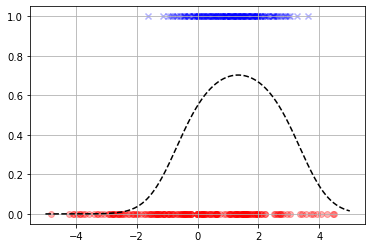

In [276]:
optim_classifier_vals = torch.exp(p_real.log_prob(x)) / (torch.exp(p_real.log_prob(x)) + torch.exp(q_real.log_prob(x)))

plt.scatter(p_samples, [1]*len(p_samples), c='b', marker='x', alpha=0.3)
plt.scatter(q_samples, [0]*len(q_samples), c='r', marker='o', alpha=0.3)
plt.plot(x, optim_classifier_vals, 'k--', label='optim classifier')
plt.grid()
plt.show()

Czyli chodzi nam o to aby zaproksymować tą funkcję, że użyciem dostępnych danych. Tutaj wchodzi probabilistyczny klasyfikator, którego
wyjściem będą wartości z przedziału [0,1].

In [371]:
from torch import nn
from datetime import datetime
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import RMSprop
from pathlib import Path


class ProbabilisticClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 32)  # input x of shape (1,)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, input_x):
        output_y = F.relu(self.fc1(input_x))
        output_y = F.relu(self.fc2(output_y))
        return torch.sigmoid(self.fc3(output_y))


p_samples_classification = p_real.sample((10000,))
q_samples_classification = q_real.sample((10000,))

data = torch.hstack((p_samples_classification, q_samples_classification))
y = torch.hstack((torch.ones_like(p_samples_classification),
                                         torch.zeros_like(q_samples_classification)))

output_folder = Path('.', 'output', f'{datetime.now().strftime("%d-%m-%Y-%H-%M-%S")}')
output_folder.mkdir(parents=True, exist_ok=True)

# First attempt using classic NN-based classifier
dataset = TensorDataset(data, y)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, drop_last=True)
model = ProbabilisticClassifier()
optimizer = RMSprop(model.parameters(), lr=0.0001)
criterion = nn.BCELoss()

for epoch in range(100):
    losses = 0
    for batch, labels in dataloader:
        optimizer.zero_grad()
        output = model(batch.unsqueeze(1))
        minibatch_loss = criterion(output.squeeze(), labels)
        minibatch_loss.backward()
        optimizer.step()
        losses += minibatch_loss

    with torch.no_grad():
        predictions = (model(x.unsqueeze(1)).squeeze())
        fig, axs = plt.subplots(1, 2, figsize=(12, 4))
        axs[1].plot(x, optim_classifier_vals, 'k--', label='P(y=1|x)')
        axs[1].plot(x, predictions, 'r:', alpha=0.8, label='estimated')
        axs[1].grid()
        axs[0].plot(x, ratio, 'k--', label='real p(q)/q(x)')
        axs[0].plot(x, torch.exp(torch.logit(predictions)), 'r:', label='estimated')
        axs[0].legend(loc='upper left')
        axs[0].grid()
        plt.savefig(output_folder / f'{epoch}.png')
        plt.close(fig)

    if epoch % 10 == 0:
        print(f'epoch idx({epoch}) with avg loss: {losses/len(dataloader)}')

epoch idx(0) with avg loss: 0.6170182228088379
epoch idx(10) with avg loss: 0.5693414807319641
epoch idx(20) with avg loss: 0.567088782787323
epoch idx(30) with avg loss: 0.5665121674537659
epoch idx(40) with avg loss: 0.5659489035606384
epoch idx(50) with avg loss: 0.5660762190818787
epoch idx(60) with avg loss: 0.5657651424407959
epoch idx(70) with avg loss: 0.5659133195877075
epoch idx(80) with avg loss: 0.5659292936325073
epoch idx(90) with avg loss: 0.5658190250396729


W końcu możemy wyestymować wartość KL z założeniem, że nie znamy p(x) ani q(x) a dysponujemy tylko samplami
z p(x).

In [383]:
with torch.no_grad():
    monte_carlo_c = torch.mean(torch.log(torch.exp(torch.logit(model(xp_mc_samples.unsqueeze(1))))))
    print(f'estimated monte carlo kl divergence: {monte_carlo_c}')


estimated monte carlo kl divergence: 0.4271441400051117
